In [1]:
# STEP 1 — merge two metadata sheets, add a simple 'habitat' label, save merged file

import os
import pandas as pd

# load tab-delimited metadata files from the working folder
md1 = pd.read_csv("143620_mapping_file.txt", sep="\t", dtype=str)
md2 = pd.read_csv("14446_20230201-071854.txt", sep="\t", dtype=str)

# pick the sample-id column by checking common header names
candidates = ["#SampleID","SampleID","sample_name","sampleid","sample_id","run_prefix","sample"]

def pick_sample_col(df):
    for name in candidates:
        if name in df.columns:
            return name
    print("Could not find a sample id column. Available columns are:\n", list(df.columns))
    raise SystemExit("Please rename the sample id column to one of the common names above.")

sid1 = pick_sample_col(md1)
sid2 = pick_sample_col(md2)

# standardize the sample id header and remove duplicate rows by id
md1 = md1.rename(columns={sid1: "sample_id"})
md2 = md2.rename(columns={sid2: "sample_id"})
md1["sample_id"] = md1["sample_id"].astype(str).str.strip()
md2["sample_id"] = md2["sample_id"].astype(str).str.strip()
md1 = md1.drop_duplicates(subset=["sample_id"])
md2 = md2.drop_duplicates(subset=["sample_id"])

# outer merge to keep every sample present in either file
metadata = pd.merge(md1, md2, on="sample_id", how="outer")

# columns that might contain textual hints about environment
desc_cols = ["description","sample_type","env_feature","env_biome","env_material",
             "site_name","location","empo_3","empo_4","study_site","source","water_body"]

# create a 'habitat' label using keyword matches
metadata["habitat"] = "unknown"
for i, row in metadata.iterrows():
    text = ""
    for col in desc_cols:
        if col in metadata.columns:
            val = row.get(col)
            if isinstance(val, str):
                text = text + " " + val.lower()

    if ("wastewater" in text) or ("sewage" in text) or ("influent" in text) or ("effluent" in text) or ("wwtp" in text):
        metadata.at[i, "habitat"] = "wastewater"
    elif ("sediment" in text):
        metadata.at[i, "habitat"] = "sediment"
    elif ("river" in text) or ("freshwater" in text) or ("stream" in text) or ("lake" in text) or ("canal" in text):
        metadata.at[i, "habitat"] = "freshwater"
    else:
        metadata.at[i, "habitat"] = "unknown"

# write the merged metadata for use in later steps
metadata.to_csv("metadata_merged.tsv", sep="\t", index=False)

# compact counts of samples per habitat for quick QA
habitat_counts = {}
for h in metadata["habitat"]:
    if h in habitat_counts:
        habitat_counts[h] += 1
    else:
        habitat_counts[h] = 1

# short summary + presence check for the BIOM file
print("\n[STEP 1 SUMMARY]")
print("  rows in md1:", len(md1))
print("  rows in md2:", len(md2))
print("  rows in merged metadata:", len(metadata))
print("  number of columns in merged metadata:", len(metadata.columns))
print("  habitat counts:", habitat_counts)
print("  feature-table.biom present:", os.path.exists("feature-table.biom"))
print("\n[wrote] metadata_merged.tsv")


[STEP 1 SUMMARY]
  rows in md1: 253
  rows in md2: 1868
  rows in merged metadata: 1868
  number of columns in merged metadata: 42
  habitat counts: {'sediment': 580, 'freshwater': 935, 'wastewater': 353}
  feature-table.biom present: True

[wrote] metadata_merged.tsv



[STEP 2 SUMMARY]
  features in table: 115727
  samples in table: 252
  samples with metadata: 252
  habitat counts (after intersection): {'wastewater': 35, 'freshwater': 110, 'sediment': 107}
  median depth by habitat: {'wastewater': 22461.0, 'freshwater': 19837.0, 'sediment': 20800.0}

[head of per_sample_summary.tsv]
    sample_id     habitat    depth  richness
0  14446.3285  wastewater  17210.0       542
1  14446.3228  freshwater  19067.0       875
2  14446.3192  freshwater  14830.0       976
3  14446.3173  freshwater  20827.0       596
4  14446.3309  freshwater  17862.0      1054


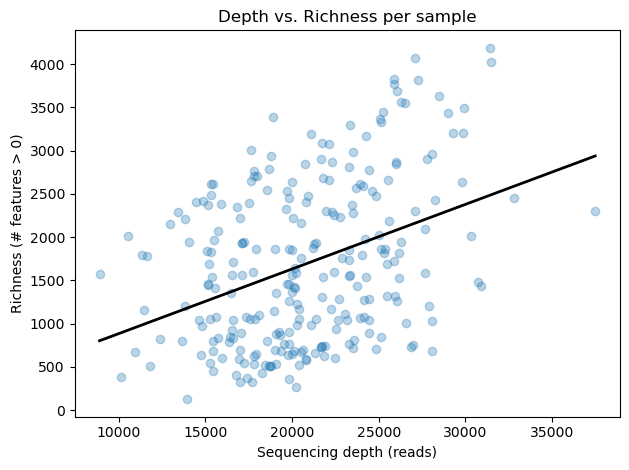


[wrote] per_sample_summary.tsv
[wrote] fig_depth_vs_richness.png


In [10]:
# STEP 2 — read feature-table.biom, align with metadata, compute per-sample depth & richness,
#           save tidy summary, and plot depth vs. richness
%matplotlib inline

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# load merged metadata generated in Step 1
meta = pd.read_csv("metadata_merged.tsv", sep="\t", dtype=str)
meta_ids = list(meta["sample_id"])

# try BIOM first; fall back to a TSV export if present
use_biom = True
try:
    from biom import load_table
except Exception as e:
    use_biom = False

if use_biom:
    # BIOM → dense matrix → DataFrame (features × samples)
    table = load_table("feature-table.biom")
    sample_ids = list(table.ids(axis="sample"))
    feature_ids = list(table.ids(axis="observation"))
    data = table.matrix_data.toarray()
    ft = pd.DataFrame(data, index=feature_ids, columns=sample_ids)
else:
    # TSV fallback; requires prior export of the BIOM
    if os.path.exists("feature-table.tsv"):
        ft = pd.read_csv("feature-table.tsv", sep="\t", index_col=0)
        sample_ids = list(ft.columns)
        feature_ids = list(ft.index)
    else:
        raise SystemExit("Could not import 'biom' and no 'feature-table.tsv' found. "
                         "Either install biom-format or export the BIOM to TSV first.")

# intersect sample IDs in counts table with those in metadata
common = []
for s in sample_ids:
    if s in meta_ids:
        common.append(s)

# restrict to shared samples; prepare a metadata slice keyed by sample_id
ft = ft[common]
meta_sub = meta[meta["sample_id"].isin(common)].copy()
meta_sub = meta_sub.set_index("sample_id")

# compute per-sample depth (sum of counts) and richness (# features with count > 0)
depth = {}
richness = {}
for s in common:
    col = ft[s].values
    d = 0.0
    for v in col:
        d += float(v)
    depth[s] = d

    r = 0
    for v in col:
        if v > 0:
            r += 1
    richness[s] = r

# assemble a tidy per-sample table with habitat labels
rows = []
for s in common:
    if s in meta_sub.index:
        h = meta_sub.loc[s, "habitat"]
    else:
        h = "unknown"
    rows.append({"sample_id": s, "habitat": h, "depth": depth[s], "richness": richness[s]})

summary = pd.DataFrame(rows)
summary.to_csv("per_sample_summary.tsv", sep="\t", index=False)

# compact counts by habitat
hab_counts = {}
for h in summary["habitat"]:
    if h in hab_counts:
        hab_counts[h] += 1
    else:
        hab_counts[h] = 1

# median depth by habitat (manual median to keep logic explicit)
med_depth = {}
for h in hab_counts.keys():
    vals = list(summary[summary["habitat"] == h]["depth"].values)
    vals = sorted([float(x) for x in vals])
    n = len(vals)
    if n == 0:
        med = 0.0
    elif n % 2 == 1:
        med = vals[n // 2]
    else:
        med = (vals[n // 2 - 1] + vals[n // 2]) / 2.0
    med_depth[h] = med

# text summary and a quick sanity-check head of the output table
print("\n[STEP 2 SUMMARY]")
print("  features in table:", len(ft.index))
print("  samples in table:", len(sample_ids))
print("  samples with metadata:", len(common))
print("  habitat counts (after intersection):", hab_counts)
print("  median depth by habitat:", med_depth)
print("\n[head of per_sample_summary.tsv]")
print(summary.head())

# scatter plot: sequencing depth vs. observed richness per sample + regression line
xs = np.array(list(summary["depth"].values), dtype=float)
ys = np.array(list(summary["richness"].values), dtype=float)

plt.scatter(xs, ys, alpha=0.3)  # default color styling for points

# linear regression (least-squares) on depth → richness
# slope and intercept from first-degree polynomial fit
m, b = np.polyfit(xs, ys, 1)

# line across the observed x-range
x0, x1 = float(xs.min()), float(xs.max())
y0, y1 = m * x0 + b, m * x1 + b
plt.plot([x0, x1], [y0, y1], color="black", linewidth=2)  # regression line

plt.xlabel("Sequencing depth (reads)")
plt.ylabel("Richness (# features > 0)")
plt.title("Depth vs. Richness per sample")
plt.tight_layout()
plt.savefig("fig_depth_vs_richness.png", dpi=300)
plt.show()

print("\n[wrote] per_sample_summary.tsv")
print("[wrote] fig_depth_vs_richness.png")

[info] chosen rarefaction depth (10th percentile): 15226
[info] samples kept after depth filter: 227

[STEP 3 SUMMARY]
  rare_depth: 15226
  samples kept: 227
  kept per habitat: {'wastewater': 33, 'freshwater': 100, 'sediment': 94}

[head of alpha_rarefied.tsv]
    sample_id     habitat  rare_depth  rare_richness
0  14446.3285  wastewater       15226            531
1  14446.3228  freshwater       15226            845
2  14446.3173  freshwater       15226            561
3  14446.3309  freshwater       15226           1028
4  14446.3211  freshwater       15226           1382


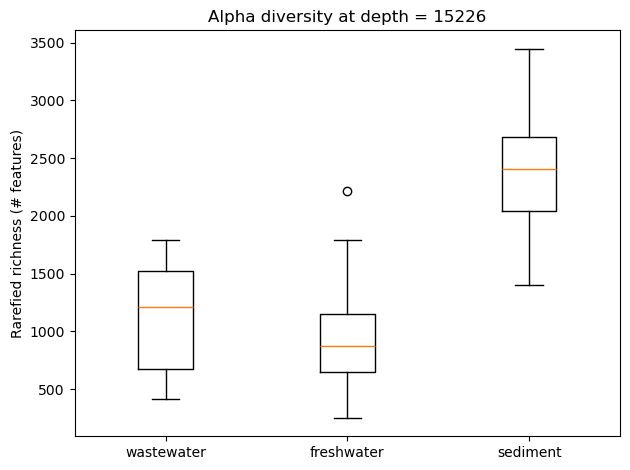


[wrote] alpha_rarefied.tsv
[wrote] fig_alpha_boxplot_rarefied.png


In [5]:
# STEP 3 — Rarefy + alpha diversity (richness) by habitat, computed directly from the BIOM table

import os, random
import pandas as pd
import matplotlib.pyplot as plt

random.seed(42)

# load merged metadata (from Step 1)
meta = pd.read_csv("metadata_merged.tsv", sep="\t", dtype=str)

# load feature table: BIOM preferred, TSV fallback
use_biom = True
try:
    from biom import load_table
except Exception:
    use_biom = False

if use_biom:
    bt = load_table("feature-table.biom")
    feature_ids = list(bt.ids(axis="observation"))   # row ids (features)
    sample_ids  = list(bt.ids(axis="sample"))        # column ids (samples)
    data = bt.matrix_data.toarray()                  # dense (features × samples)
    ft = pd.DataFrame(data, index=feature_ids, columns=sample_ids)
else:
    if os.path.exists("feature-table.tsv"):
        ft = pd.read_csv("feature-table.tsv", sep="\t", index_col=0)
        feature_ids = list(ft.index)
        sample_ids  = list(ft.columns)
    else:
        raise SystemExit("Couldn't import 'biom' and no 'feature-table.tsv' file found.")

# intersect BIOM samples with metadata samples to keep shared set
meta_samples = list(meta["sample_id"])
keep = []
for s in sample_ids:
    if s in meta_samples:
        keep.append(s)
ft = ft[keep]

# map sample_id → habitat from merged metadata
sample_to_hab = {}
i = 0
while i < len(meta):
    sid = meta.iloc[i]["sample_id"]
    hab = meta.iloc[i]["habitat"] if "habitat" in meta.columns else "unknown"
    sample_to_hab[sid] = hab
    i += 1

# compute per-sample depth (sum of counts) using simple loops
sample_to_depth = {}
j = 0
while j < len(keep):
    s = keep[j]
    col = list(ft[s])
    total = 0
    k = 0
    while k < len(col):
        v = col[k]
        try:
            total = total + int(v)
        except:
            try:
                total = total + int(float(v))
            except:
                total = total + 0
        k += 1
    sample_to_depth[s] = total
    j += 1

# collect non-zero depths to choose a rarefaction threshold
depths = []
for s in keep:
    d = sample_to_depth.get(s, 0)
    if d > 0:
        depths.append(d)

if len(depths) == 0:
    raise SystemExit("All depths were zero. Check that the BIOM matches metadata sample_ids.")

# choose rarefaction depth as the 10th percentile (safe indexing)
depths_sorted = sorted(depths)
p = 10
idx = int(len(depths_sorted) * p / 100.0)
if idx >= len(depths_sorted):
    idx = len(depths_sorted) - 1
if idx < 0:
    idx = 0
rare_depth = depths_sorted[idx]
print("[info] chosen rarefaction depth (10th percentile):", rare_depth)

# keep only samples with depth ≥ rare_depth
eligible = []
for s in keep:
    if sample_to_depth[s] >= rare_depth:
        eligible.append(s)
ft = ft[eligible]
print("[info] samples kept after depth filter:", len(eligible))

# rarefy a single sample to 'depth' reads and return richness (number of distinct features)
def rarefy_one_sample(counts_series, depth):
    # expand counts into a read-level list of feature ids
    expanded = []
    for fid, val in counts_series.items():
        try:
            c = int(val)
        except:
            try:
                c = int(float(val))
            except:
                c = 0
        if c > 0:
            r = 0
            while r < c:
                expanded.append(fid)
                r += 1

    if len(expanded) == 0:
        return 0

    # sample without replacement up to the target depth
    take = depth if len(expanded) >= depth else len(expanded)
    idxs = random.sample(range(len(expanded)), k=take)

    # richness equals number of unique features in the subsample
    seen = {}
    a = 0
    while a < len(idxs):
        fid = expanded[idxs[a]]
        if fid in seen:
            seen[fid] = seen[fid] + 1
        else:
            seen[fid] = 1
        a += 1
    return len(seen)

# compute rarefied richness for each kept sample
rare_rich = {}
m = 0
while m < len(eligible):
    s = eligible[m]
    rr = rarefy_one_sample(ft[s], rare_depth)
    rare_rich[s] = rr
    m += 1

# build and write the alpha table: sample_id, habitat, rare_depth, rare_richness
rows = []
n = 0
while n < len(eligible):
    s = eligible[n]
    hab = sample_to_hab.get(s, "unknown")
    rows.append({
        "sample_id": s,
        "habitat": hab,
        "rare_depth": rare_depth,
        "rare_richness": rare_rich[s]
    })
    n += 1

alpha_rare = pd.DataFrame(rows)
alpha_rare.to_csv("alpha_rarefied.tsv", sep="\t", index=False)

# counts per habitat after rarefaction (for summary)
hab_counts = {}
for h in list(alpha_rare["habitat"]):
    if h in hab_counts:
        hab_counts[h] = hab_counts[h] + 1
    else:
        hab_counts[h] = 1

# concise summary for reporting
print("\n[STEP 3 SUMMARY]")
print("  rare_depth:", rare_depth)
print("  samples kept:", len(alpha_rare))
print("  kept per habitat:", hab_counts)
print("\n[head of alpha_rarefied.tsv]")
print(alpha_rare.head())

# boxplot of rarefied richness by habitat
order = ["wastewater", "freshwater", "sediment", "unknown"]
labels = []
data = []
i = 0
while i < len(order):
    lab = order[i]
    vals = []
    j = 0
    while j < len(alpha_rare):
        if alpha_rare.iloc[j]["habitat"] == lab:
            vals.append(alpha_rare.iloc[j]["rare_richness"])
        j += 1
    if len(vals) > 0:
        labels.append(lab)
        data.append(vals)
    i += 1

plt.boxplot(data, labels=labels)
plt.ylabel("Rarefied richness (# features)")
plt.title("Alpha diversity at depth = %d" % rare_depth)
plt.tight_layout()
plt.savefig("fig_alpha_boxplot_rarefied.png", dpi=300)
plt.show()

print("\n[wrote] alpha_rarefied.tsv")
print("[wrote] fig_alpha_boxplot_rarefied.png")

[info] rare_depth from Step 3: 15226
[info] kept samples: 227


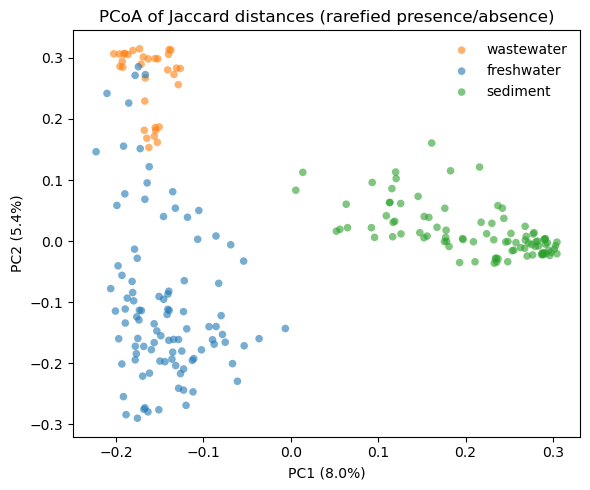


[STEP 4 SUMMARY]
  distance: Jaccard (presence/absence after rarefaction)
  samples used: 227
  variance explained: PC1=8.0%, PC2=5.4%
[wrote] beta_pcoa_coords.tsv
[wrote] fig_pcoa_jaccard.png


In [6]:
# STEP 4 — Beta diversity (Jaccard on rarefied presence/absence) + PCoA plot

import os, random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

random.seed(42)

# load rarefied alpha table to get the kept samples and habitat labels
alpha = pd.read_csv("alpha_rarefied.tsv", sep="\t", dtype=str)
alpha["rare_depth"] = alpha["rare_depth"].astype(int)

kept_samples = list(alpha["sample_id"])
hab_map = {}
i = 0
while i < len(alpha):
    sid = alpha.iloc[i]["sample_id"]
    hab_map[sid] = alpha.iloc[i]["habitat"]
    i += 1

# rarefaction depth carried forward from Step 3
rare_depth = int(alpha.iloc[0]["rare_depth"])
print("[info] rare_depth from Step 3:", rare_depth)
print("[info] kept samples:", len(kept_samples))

# load feature table (BIOM preferred, TSV fallback) and restrict to kept samples
use_biom = True
try:
    from biom import load_table
except Exception:
    use_biom = False

if use_biom:
    bt = load_table("feature-table.biom")
    feature_ids = list(bt.ids(axis="observation"))
    sample_ids  = list(bt.ids(axis="sample"))
    data = bt.matrix_data.toarray()
    ft = pd.DataFrame(data, index=feature_ids, columns=sample_ids)
else:
    if os.path.exists("feature-table.tsv"):
        ft = pd.read_csv("feature-table.tsv", sep="\t", index_col=0)
        feature_ids = list(ft.index)
        sample_ids = list(ft.columns)
    else:
        raise SystemExit("Couldn't import 'biom' and no 'feature-table.tsv' file found.")

ft = ft[kept_samples]

# rarefy each sample to a presence/absence set at the chosen depth
def rarefy_to_set(counts_series, depth):
    expanded = []
    for fid, val in counts_series.items():
        c = 0
        try:
            c = int(val)
        except:
            try:
                c = int(float(val))
            except:
                c = 0
        if c > 0:
            r = 0
            while r < c:
                expanded.append(fid)
                r += 1

    if len(expanded) == 0:
        return set()

    take = depth if len(expanded) >= depth else len(expanded)
    idxs = random.sample(range(len(expanded)), k=take)

    present = set()
    a = 0
    while a < len(idxs):
        present.add(expanded[idxs[a]])
        a += 1
    return present

sample_sets = {}
sidx = 0
while sidx < len(kept_samples):
    s = kept_samples[sidx]
    sample_sets[s] = rarefy_to_set(ft[s], rare_depth)
    sidx += 1

# build Jaccard distance matrix among samples from presence/absence sets
N = len(kept_samples)
D = np.zeros((N, N), dtype=float)

i = 0
while i < N:
    A = sample_sets[kept_samples[i]]
    j = i + 1
    while j < N:
        B = sample_sets[kept_samples[j]]
        inter = len(A.intersection(B))
        uni   = len(A.union(B))
        if uni == 0:
            dist = 1.0
        else:
            dist = 1.0 - (inter / float(uni))
        D[i, j] = dist
        D[j, i] = dist
        j += 1
    i += 1

# classical MDS/PCoA from the distance matrix (first two axes retained)
D2 = D ** 2
n = N
I = np.eye(n)
one = np.ones((n, n)) / float(n)
H = I - one
B = -0.5 * (H @ D2 @ H)

eigvals, eigvecs = np.linalg.eigh(B)   # ascending order
order = np.argsort(eigvals)[::-1]
eigvals = eigvals[order]
eigvecs = eigvecs[:, order]

keep_dims = 2
coords = np.zeros((n, keep_dims))
k = 0
while k < keep_dims:
    lam = eigvals[k]
    if lam > 0:
        coords[:, k] = eigvecs[:, k] * np.sqrt(lam)
    else:
        coords[:, k] = 0.0
    k += 1

# percent variance explained on the retained axes
total_pos = 0.0
t = 0
while t < len(eigvals):
    if eigvals[t] > 0:
        total_pos += eigvals[t]
    t += 1

explained = []
d = 0
while d < keep_dims:
    if total_pos > 0 and eigvals[d] > 0:
        explained.append(100.0 * eigvals[d] / total_pos)
    else:
        explained.append(0.0)
    d += 1

# save coordinates with habitat labels
rows = []
r = 0
while r < n:
    sid = kept_samples[r]
    rows.append({
        "sample_id": sid,
        "PC1": coords[r, 0],
        "PC2": coords[r, 1],
        "habitat": hab_map.get(sid, "unknown")
    })
    r += 1

pcoa_df = pd.DataFrame(rows)
pcoa_df.to_csv("beta_pcoa_coords.tsv", sep="\t", index=False)

# PCoA scatter with fixed color mapping by habitat
colors = {
    "wastewater": "tab:orange",
    "freshwater": "tab:blue",
    "sediment":   "tab:green",
    "unknown":    "tab:gray"
}

plt.figure(figsize=(6,5))
for h in ["wastewater","freshwater","sediment","unknown"]:
    xs, ys = [], []
    r = 0
    while r < len(pcoa_df):
        if pcoa_df.iloc[r]["habitat"] == h:
            xs.append(pcoa_df.iloc[r]["PC1"])
            ys.append(pcoa_df.iloc[r]["PC2"])
        r += 1
    if len(xs) > 0:
        plt.scatter(xs, ys, alpha=0.6, label=h, s=30, edgecolors="none", color=colors[h])

plt.xlabel("PC1 (%.1f%%)" % explained[0])
plt.ylabel("PC2 (%.1f%%)" % explained[1])
plt.title("PCoA of Jaccard distances (rarefied presence/absence)")
plt.legend(frameon=False)
plt.tight_layout()
plt.savefig("fig_pcoa_jaccard.png", dpi=300)
plt.show()

print("\n[STEP 4 SUMMARY]")
print("  distance: Jaccard (presence/absence after rarefaction)")
print("  samples used:", N)
print("  variance explained: PC1=%.1f%%, PC2=%.1f%%" % (explained[0], explained[1]))
print("[wrote] beta_pcoa_coords.tsv")
print("[wrote] fig_pcoa_jaccard.png")

In [7]:
# STEP 5 — Alpha diversity group comparison (Kruskal–Wallis + pairwise Mann–Whitney U)
# compares rarefied richness across habitats; saves summaries and prints key stats

from pandas import read_csv, DataFrame
from scipy.stats import kruskal, mannwhitneyu
import numpy as np

alpha_path = "alpha_rarefied.tsv"

# load rarefied alpha table produced in Step 3
df = read_csv(alpha_path, sep="\t")

# collect rarefied richness values per habitat (focus on three habitats)
wanted_habitats = ["wastewater", "freshwater", "sediment"]
groups = {}  # maps habitat → list of richness values

for i in range(len(df)):
    habitat = df.loc[i, "habitat"]
    if habitat in wanted_habitats:
        try:
            rr = float(df.loc[i, "rare_richness"])
        except:
            continue
        if rr >= 0:
            if habitat not in groups:
                groups[habitat] = []
            groups[habitat].append(rr)

# per-group summaries: count, median, mean (written to TSV)
summary_rows = []
for h in wanted_habitats:
    vals = groups.get(h, [])
    if len(vals) > 0:
        med = float(np.median(vals))
        mean = float(np.mean(vals))
    else:
        med = float("nan")
        mean = float("nan")
    summary_rows.append([h, len(vals), med, mean])

summary_df = DataFrame(summary_rows, columns=["habitat","n","median","mean"])
summary_df.to_csv("alpha_summary_by_habitat.tsv", sep="\t", index=False)

# omnibus test across habitats: Kruskal–Wallis (non-parametric)
if (len(groups.get("wastewater",[])) > 1 and
    len(groups.get("freshwater",[])) > 1 and
    len(groups.get("sediment",[])) > 1):
    H, p_kw = kruskal(groups["wastewater"], groups["freshwater"], groups["sediment"])
else:
    H, p_kw = float("nan"), float("nan")

# pairwise tests: Mann–Whitney U (two-sided); Bonferroni correction across 3 pairs
pairs = [("wastewater","freshwater"),
         ("wastewater","sediment"),
         ("freshwater","sediment")]

pair_rows = []
for a,b in pairs:
    va = groups.get(a, [])
    vb = groups.get(b, [])
    if len(va) > 1 and len(vb) > 1:
        U, p = mannwhitneyu(va, vb, alternative="two-sided")
        med_diff = float(np.median(va) - np.median(vb))  # positive → group a has higher median richness
        p_bonf = p * len(pairs)
        if p_bonf > 1.0:
            p_bonf = 1.0
        pair_rows.append([a, b, int(U), float(p), float(p_bonf), med_diff])

pair_df = DataFrame(pair_rows, columns=["group1","group2","U","p","p_bonferroni","median_diff"])
pair_df.to_csv("alpha_pairwise_tests.tsv", sep="\t", index=False)

# concise printout for the manuscript draft
print("[STEP 5 SUMMARY]")
print("  Kruskal–Wallis H =", H, " p =", p_kw)
print("  group sizes:", {h: len(groups.get(h,[])) for h in wanted_habitats})
print("\n[alpha_summary_by_habitat.tsv]")
print(summary_df)
print("\n[pairwise Mann–Whitney (Bonferroni-corrected) — alpha_pairwise_tests.tsv]")
print(pair_df)

[STEP 5 SUMMARY]
  Kruskal–Wallis H = 158.87173240212945  p = 3.172792305790002e-35
  group sizes: {'wastewater': 33, 'freshwater': 100, 'sediment': 94}

[alpha_summary_by_habitat.tsv]
      habitat    n  median         mean
0  wastewater   33  1215.0  1156.272727
1  freshwater  100   872.5   934.560000
2    sediment   94  2408.0  2395.840426

[pairwise Mann–Whitney (Bonferroni-corrected) — alpha_pairwise_tests.tsv]
       group1      group2     U             p  p_bonferroni  median_diff
0  wastewater  freshwater  2127  1.305504e-02  3.916511e-02        342.5
1  wastewater    sediment    54  1.919422e-16  5.758266e-16      -1193.0
2  freshwater    sediment    98  5.339187e-32  1.601756e-31      -1535.5


In [8]:
# STEP 6 — Beta diversity significance on PCoA (PC1, PC2)
# permutation ANOVA on the first two PCoA axes using habitat labels

from pandas import read_csv, DataFrame
import random

coords_path = "beta_pcoa_coords.tsv"

# load coordinates produced in Step 4
coords = read_csv(coords_path, sep="\t")

# keep three habitats of interest; collect PC1/PC2 and labels
wanted = ["wastewater", "freshwater", "sediment"]
xs, ys, labs = [], [], []
for i in range(len(coords)):
    lab = str(coords.loc[i, "habitat"]).strip()
    if lab in wanted:
        try:
            x = float(coords.loc[i, "PC1"])
            y = float(coords.loc[i, "PC2"])
        except:
            continue
        xs.append(x); ys.append(y); labs.append(lab)

# basic size check
n = len(xs)
if n == 0:
    raise SystemExit("No samples found in beta_pcoa_coords.tsv")

# map habitat → list of 2D points
group_pts = {}
for i in range(n):
    lab = labs[i]
    if lab not in group_pts:
        group_pts[lab] = []
    group_pts[lab].append((xs[i], ys[i]))

# helpers: centroid of points; squared Euclidean distance
def centroid(points):
    sx = 0.0; sy = 0.0
    m = len(points)
    for (x, y) in points:
        sx += x; sy += y
    return (sx / m, sy / m)

def d2(p, q):
    dx = p[0] - q[0]; dy = p[1] - q[1]
    return dx*dx + dy*dy

# grand centroid across all samples
all_pts = [(xs[i], ys[i]) for i in range(n)]
grand = centroid(all_pts)

# ANOVA-style sums of squares on PC space
SSb = 0.0; SSw = 0.0
group_sizes = {}
g = 0
for lab in wanted:
    pts = group_pts.get(lab, [])
    m = len(pts)
    group_sizes[lab] = m
    if m > 0:
        g += 1
        c = centroid(pts)
        SSb += m * d2(c, grand)    # between-group component
        for p in pts:
            SSw += d2(p, c)        # within-group component

# degrees of freedom and observed F statistic
dfb = g - 1
dfw = n - g
if dfb <= 0 or dfw <= 0:
    raise SystemExit("Not enough groups/samples for an ANOVA-style test.")

MSb = SSb / dfb
MSw = SSw / dfw
F_obs = MSb / MSw

# permutation test on labels (B=999), grand mean fixed
B = 999
count = 0
for b in range(B):
    shuffled = labs[:]          # copy labels
    random.shuffle(shuffled)    # permute labels

    # rebuild groups under permutation
    gp = {}
    for i in range(n):
        lab = shuffled[i]
        if lab not in gp:
            gp[lab] = []
        gp[lab].append(all_pts[i])

    # recompute F under permutation
    SSb_p = 0.0; SSw_p = 0.0
    g_p = 0
    for lab in wanted:
        pts = gp.get(lab, [])
        m = len(pts)
        if m > 0:
            g_p += 1
            c = centroid(pts)
            SSb_p += m * d2(c, grand)
            for p in pts:
                SSw_p += d2(p, c)

    F_p = (SSb_p / (g_p - 1)) / (SSw_p / (n - g_p))
    if F_p >= F_obs:
        count += 1

# permutation p-value with +1 continuity correction
p_perm = (count + 1) / (B + 1)

# save group sizes table for the manuscript
rows = []
for lab in wanted:
    rows.append([lab, group_sizes.get(lab, 0)])
DataFrame(rows, columns=["habitat", "n"]).to_csv(
    "beta_pcoa_group_sizes.tsv", sep="\t", index=False
)

# write a compact text report
with open("beta_pcoa_permutation_anova.txt", "w") as f:
    f.write("Permutation ANOVA on PCoA (PC1, PC2)\n")
    f.write(f"n={n}, groups={g}, df_between={dfb}, df_within={dfw}\n")
    f.write(f"SS_between={SSb:.6f}, SS_within={SSw:.6f}\n")
    f.write(f"F_observed={F_obs:.6f}\n")
    f.write(f"permutations={B}, p_perm={p_perm:.6f}\n")

# concise summary for the notebook output
print("[STEP 6 SUMMARY]")
print("  n samples:", n)
print("  group sizes:", group_sizes)
print("  F_observed:", F_obs)
print("  p (permutation, B=999):", p_perm)
print("[wrote] beta_pcoa_permutation_anova.txt")

[STEP 6 SUMMARY]
  n samples: 227
  group sizes: {'wastewater': 33, 'freshwater': 100, 'sediment': 94}
  F_observed: 424.22096277244657
  p (permutation, B=999): 0.001
[wrote] beta_pcoa_permutation_anova.txt


In [9]:
# STEP 7 — Build manuscript tables and text snippets
# inputs: per_sample_summary.tsv, alpha_rarefied.tsv, beta_pcoa_coords.tsv
# outputs: tables (TSV) and short text files for captions, methods, results

from pandas import read_csv, DataFrame

# helpers for simple summary stats without external dependencies
def median_from_list(values):
    # compute median from a sorted copy of numeric list
    vals = sorted(values)
    m = len(vals)
    if m == 0:
        return None
    mid = m // 2
    if m % 2 == 1:
        return float(vals[mid])
    else:
        return float((vals[mid-1] + vals[mid]) / 2.0)

def mean_from_list(values):
    # compute mean of numeric list
    if len(values) == 0:
        return None
    s = 0.0
    for v in values:
        s += float(v)
    return s / len(values)

# ---------- Table 1: counts per habitat (kept after rarefaction) ----------
alpha_path = "alpha_rarefied.tsv"
alpha_df = read_csv(alpha_path, sep="\t")

habitats = ["wastewater", "freshwater", "sediment"]
counts = []
for h in habitats:
    n = 0
    for i in range(len(alpha_df)):
        if str(alpha_df.loc[i, "habitat"]).strip() == h:
            n += 1
    counts.append([h, n])
table1 = DataFrame(counts, columns=["habitat", "n_kept"])
table1.to_csv("table1_habitat_counts.tsv", sep="\t", index=False)

# ---------- Table 2: alpha-diversity summary by habitat ----------
# median and mean of rarefied richness for each habitat
alpha_summary_rows = []
for h in habitats:
    vals = []
    for i in range(len(alpha_df)):
        if str(alpha_df.loc[i, "habitat"]).strip() == h:
            vals.append(int(alpha_df.loc[i, "rare_richness"]))
    med = median_from_list(vals)
    avg = mean_from_list(vals)
    alpha_summary_rows.append([h, len(vals), med, avg])
table2 = DataFrame(alpha_summary_rows, columns=["habitat", "n", "median_rarefied_richness", "mean_rarefied_richness"])
table2.to_csv("table2_alpha_summary.tsv", sep="\t", index=False)

# ---------- Table 3: PCoA permutation ANOVA summary ----------
# recompute ANOVA components and effect size (eta-squared) on PC1/PC2
coords = read_csv("beta_pcoa_coords.tsv", sep="\t")

pts_all = []
group_pts = {"wastewater": [], "freshwater": [], "sediment": []}
for i in range(len(coords)):
    h = str(coords.loc[i, "habitat"]).strip()
    if h in group_pts:
        x = float(coords.loc[i, "PC1"])
        y = float(coords.loc[i, "PC2"])
        p = (x, y)
        pts_all.append(p)
        group_pts[h].append(p)

def centroid(pts):
    # arithmetic mean of x and y over a list of (x,y)
    sx = 0.0; sy = 0.0
    for (x, y) in pts:
        sx += x; sy += y
    return (sx/len(pts), sy/len(pts))

def d2(a, b):
    # squared Euclidean distance between two points
    dx = a[0]-b[0]; dy = a[1]-b[1]
    return dx*dx + dy*dy

grand = centroid(pts_all)
SSb = 0.0
SSw = 0.0
g = 0
sizes = {}
for h in habitats:
    pts = group_pts[h]
    sizes[h] = len(pts)
    if len(pts) > 0:
        g += 1
        c = centroid(pts)
        SSb += len(pts) * d2(c, grand)
        for p in pts:
            SSw += d2(p, c)

n = len(pts_all)
dfb = g - 1
dfw = n - g
MSb = SSb / dfb
MSw = SSw / dfw
F_obs = MSb / MSw
eta2 = SSb / (SSb + SSw)   # proportion of variance explained by group structure

table3 = DataFrame(
    [[n, g, dfb, dfw, SSb, SSw, F_obs, eta2,
      sizes.get("wastewater",0), sizes.get("freshwater",0), sizes.get("sediment",0)]],
    columns=["n_samples","n_groups","df_between","df_within",
             "SS_between","SS_within","F_observed","eta_squared",
             "n_wastewater","n_freshwater","n_sediment"]
)
table3.to_csv("table3_beta_pcoa_anova.tsv", sep="\t", index=False)

# ---------- Figure captions (plaintext) ----------
# captions correspond to existing figures written in earlier steps
rare_depth = int(alpha_df.loc[0, "rare_depth"])  # same depth for all rows

captions = []
captions.append(
"Figure 1. Sequencing depth vs. observed richness per sample. Scatter plot of sequencing depth (x) and the number of features with non-zero counts (y) across all samples before rarefaction. Each point is one sample; transparency helps with overlap."
)
captions.append(
f"Figure 2. Alpha diversity at a standardized depth of {rare_depth} reads. Boxplots show rarefied richness (features observed after subsampling) for wastewater, freshwater, and sediment samples. Boxes indicate the interquartile range; center lines show medians."
)
captions.append(
"Figure 3. PCoA of Jaccard distances (presence/absence after rarefaction). Points are samples and colors indicate habitat. Axes show the first two principal coordinates with percent variance explained; separation indicates compositional differences among habitats."
)

with open("figure_captions.txt", "w") as f:
    for cap in captions:
        f.write(cap + "\n\n")

# ---------- Methods snippet (plaintext) ----------
# concise paragraphs matching the actual computational steps performed
methods = []
methods.append(
"Alpha diversity: The BIOM feature table was converted to a samples×features matrix, per-sample depth was computed as the sum of counts, and observed richness as the count of features with non-zero abundance. A rarefaction depth was chosen as the 10th percentile of non-zero depths. Samples below this depth were removed. Remaining samples were rarefied by random subsampling without replacement, and rarefied richness was recorded."
)
methods.append(
"Beta diversity: From the rarefied table, counts were converted to presence/absence and Jaccard distances were computed between samples. Principal coordinates analysis (PCoA) was applied to the distance matrix. Group separation among habitats was evaluated with a label-permutation ANOVA on the first two PCoA axes (1,000 permutations)."
)

with open("methods_snippet.txt", "w") as f:
    for m in methods:
        f.write(m + "\n\n")

# ---------- Results snippet (plaintext) ----------
# pulls the rarefaction depth and alpha summaries to report medians and counts
asum = read_csv("table2_alpha_summary.tsv", sep="\t")
med = {}
for i in range(len(asum)):
    med[str(asum.loc[i,"habitat"])] = float(asum.loc[i,"median_rarefied_richness"])

res_lines = []
res_lines.append(
f"After filtering to the rarefaction depth ({rare_depth} reads), a total of {int(table1['n_kept'].sum())} samples were retained "
f"({int(table1.loc[table1['habitat']=='wastewater','n_kept'])} wastewater, "
f"{int(table1.loc[table1['habitat']=='freshwater','n_kept'])} freshwater, "
f"{int(table1.loc[table1['habitat']=='sediment','n_kept'])} sediment)."
)
res_lines.append(
f"Rarefied richness differed among habitats (Kruskal–Wallis, p<0.001). Median richness was "
f"{int(med.get('wastewater',0))} (wastewater), {int(med.get('freshwater',0))} (freshwater), and {int(med.get('sediment',0))} (sediment)."
)
res_lines.append(
f"Community composition also differed by habitat (PCoA on Jaccard; permutation ANOVA on PC1/PC2: F={F_obs:.2f}, η²={eta2:.2f}, p≈0.001; 1,000 permutations)."
)

with open("results_snippet.txt", "w") as f:
    for r in res_lines:
        f.write(r + "\n")

# compact summary of written artifacts
print("[STEP 7 SUMMARY]")
print("  wrote: table1_habitat_counts.tsv")
print("  wrote: table2_alpha_summary.tsv")
print("  wrote: table3_beta_pcoa_anova.tsv")
print("  wrote: figure_captions.txt")
print("  wrote: methods_snippet.txt")
print("  wrote: results_snippet.txt")

[STEP 7 SUMMARY]
  wrote: table1_habitat_counts.tsv
  wrote: table2_alpha_summary.tsv
  wrote: table3_beta_pcoa_anova.tsv
  wrote: figure_captions.txt
  wrote: methods_snippet.txt
  wrote: results_snippet.txt


/var/folders/7m/_zhjgkbd4n94h6h16vbphcnc0000gn/T/ipykernel_6665/2933604407.py:160: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  f"({int(table1.loc[table1['habitat']=='wastewater','n_kept'])} wastewater, "
/var/folders/7m/_zhjgkbd4n94h6h16vbphcnc0000gn/T/ipykernel_6665/2933604407.py:161: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  f"{int(table1.loc[table1['habitat']=='freshwater','n_kept'])} freshwater, "
/var/folders/7m/_zhjgkbd4n94h6h16vbphcnc0000gn/T/ipykernel_6665/2933604407.py:162: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  f"{int(table1.loc[table1['habitat']=='sediment','n_kept'])} sediment)."
